# Tutorial: Sit to Stand and Stand to Sit Detection

**Author:** Masoud Abedinifar

**Last update:** Mon 13 May. 2024

## Learning objectives
By the end of this tutorial:
- You can load data from a recording that belongs to one of the available datasets,
- Apply the Pham Sit to Stand and Stand to Sit Detection algorithm.
- Visualize the results of the algorithm.  
- Interpret the detected postural transitions (sit to stand and stand to sit) for further analysis.

# Pham Sit to Stand and Stand to Sit Detection

This example can be referenced by citing the package.

The example illustrates how to use PhamSittoStandStandtoSitDetection algorithm to detect sit to stand and stand to sit movements using body acceleration and gyro data recorded with a lower back IMU sensor. The sit to stand and stand to sit detection algorithm is implemented using [`ngmt.modules.ssd._pham`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/ssd/_pham.py). This algorithm is based on the research of Pham et al [1].

This algorithm aims to detect postural transitions (e.g., sit-to-stand or stand-to-sit movements) using accelerometer and gyroscope data collected from a lower back inertial measurement unit (IMU) sensor. This algorithm is designed to be robust in detecting sit-to-stand and stand-to-sit transitions using inertial sensor data and provides detailed information about these transitions.

The algorithm starts by loading the accelerometer and gyro data, which includes three columns corresponding to the acceleration and gyro signals across the x, y, and z axes, along with the sampling frequency of the data. It first checks the validity of the input data. Then, it calculates the sampling period, selects accelerometer and gyro data. Tilt angle estimation is performed using gyro data. The tilt angle is decomposed using wavelet transformation to identify stationary periods. Stationary periods are detected using accelerometer variance and gyro variance.Then, peaks in the wavelet-transformed tilt signal are detected as potential postural transition events. 

If there's enough stationary data, further processing is done to estimate the orientation using quaternions and to identify the beginning and end of postural transitions using gyro data. Otherwise, if there's insufficient stationary data, direction changes in gyro data are used to infer postural transitions.

Finally, the detected postural transitions are classified as either sit-to-stand or stand-to-sit based on gyro data characteristics and other criteria. The detected postural transitions along with their characteristics (onset time, duration, event type, angle, maximum flexion/extension velocity, tracking systems, and tracked points) are stored in a pandas DataFrame (postural_transitions_ attribute).

If requested (`plot_results` set to True), it generates plots of the accelerometer and gyroscope data along with the detected postural transitions.

#### References
[1] Pham et al. (2018). Validation of a Lower Back "Wearable"-Based Sit-to-Stand and  Stand-to-Sit Algorithm for Patients With Parkinson's Disease and Older Adults in a Home-Like  Environment. Frontiers in Neurology, 9, 652. https://doi.org/10.3389/fneur.2018.00652

## Import libraries
The necessary libraries such as numpy, matplotlib.pyplot, dataset and PhamSittoStandStandtoSitDetection sit to stand and stand to sit detection algortihm are imported. Make sure that you have all the required libraries and modules installed before running this code. You also may need to install the `ngmt` library and its dependencies if you haven't already.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngmt.datasets import keepcontrol
from ngmt.modules.ssd import PhamSittoStandStandtoSitDetection

## Data Preparation

To implement Pham Sit to Stand and Stand to Sit Detection algorithm, we load example data.


In [2]:
# The 'file_path' variable holds the absolute path to the data file
file_path = (
    r"\Keep Control\Data\lab dataset\rawdata\sub-pp002\motion\sub-pp002_task-tug_tracksys-imu_motion.tsv"
)

In [3]:
# In this example, we use "imu" as tracking_system and "pelvis" as tracked points.
tracking_sys = "imu"
tracked_points = {tracking_sys: ["pelvis"]}

In [4]:
# The 'keepcontrol.load_recording' function is used to load the data from the specified file_path
recording = keepcontrol.load_recording(
    file_name=file_path, tracking_systems=[tracking_sys], tracked_points=tracked_points
)

In [5]:
# Load lower back acceleration data
acceleration_data = recording.data[tracking_sys][
    ["pelvis_ACC_x", "pelvis_ACC_y", "pelvis_ACC_z"]
]

# Get the acceleration data unit from the recording
acceleration_data_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ACC", case=False)
]["units"].iloc[0]

# Print acceleration data
print(f"acceleration_data ({acceleration_data_unit}): {acceleration_data}")

acceleration_data (g):       pelvis_ACC_x  pelvis_ACC_y  pelvis_ACC_z
0         0.920901     -0.047850     -0.400888
1         0.919441     -0.051282     -0.392583
2         0.922828     -0.047359     -0.392093
3         0.926741     -0.048830     -0.384279
4         0.918973     -0.053218     -0.397947
...            ...           ...           ...
2903      0.966803     -0.027822     -0.279782
2904      0.957517     -0.035152     -0.285636
2905      0.960437     -0.034171     -0.291979
2906      0.962890     -0.036623     -0.299794
2907      0.963883     -0.038584     -0.294921

[2908 rows x 3 columns]


In [6]:
# Load lower back gyro data
gyro_data = recording.data[tracking_sys][
    ["pelvis_ANGVEL_x", "pelvis_ANGVEL_y", "pelvis_ANGVEL_z"]
]

# Get the gyro data unit from the recording
gyro_data_unit = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"].str.contains("ANGVEL", case=False)
]["units"].iloc[0]

# Print gyro data
print(f"gyro_data ({gyro_data_unit}): {gyro_data}")

gyro_data (deg/s):       pelvis_ANGVEL_x  pelvis_ANGVEL_y  pelvis_ANGVEL_z
0            0.000000        -0.614677         0.436291
1            0.000000        -0.700049         0.176093
2           -0.172905        -0.261807        -0.262826
3            0.262815        -0.261807         0.000000
4            0.608625        -0.614677        -0.349559
...               ...              ...              ...
2903        -0.089911        -1.309034         0.000000
2904         0.525631        -0.438242        -0.436291
2905         0.871441        -0.961855         0.086733
2906         1.051262        -0.700049         0.176093
2907         1.134256        -0.347179        -0.525652

[2908 rows x 3 columns]


In [7]:
# Get the corresponding sampling frequency directly from the recording
sampling_frequency = recording.channels[tracking_sys][
    recording.channels[tracking_sys]["name"] == "pelvis_ACC_x"
]["sampling_frequency"].values[0]

# Print sampling frequency
print(f"sampling frequency: {sampling_frequency} Hz")

sampling frequency: 200 Hz


## Visualisation of the Data
The raw acceleration and gyro data including components of x, y and z axis are plotted.

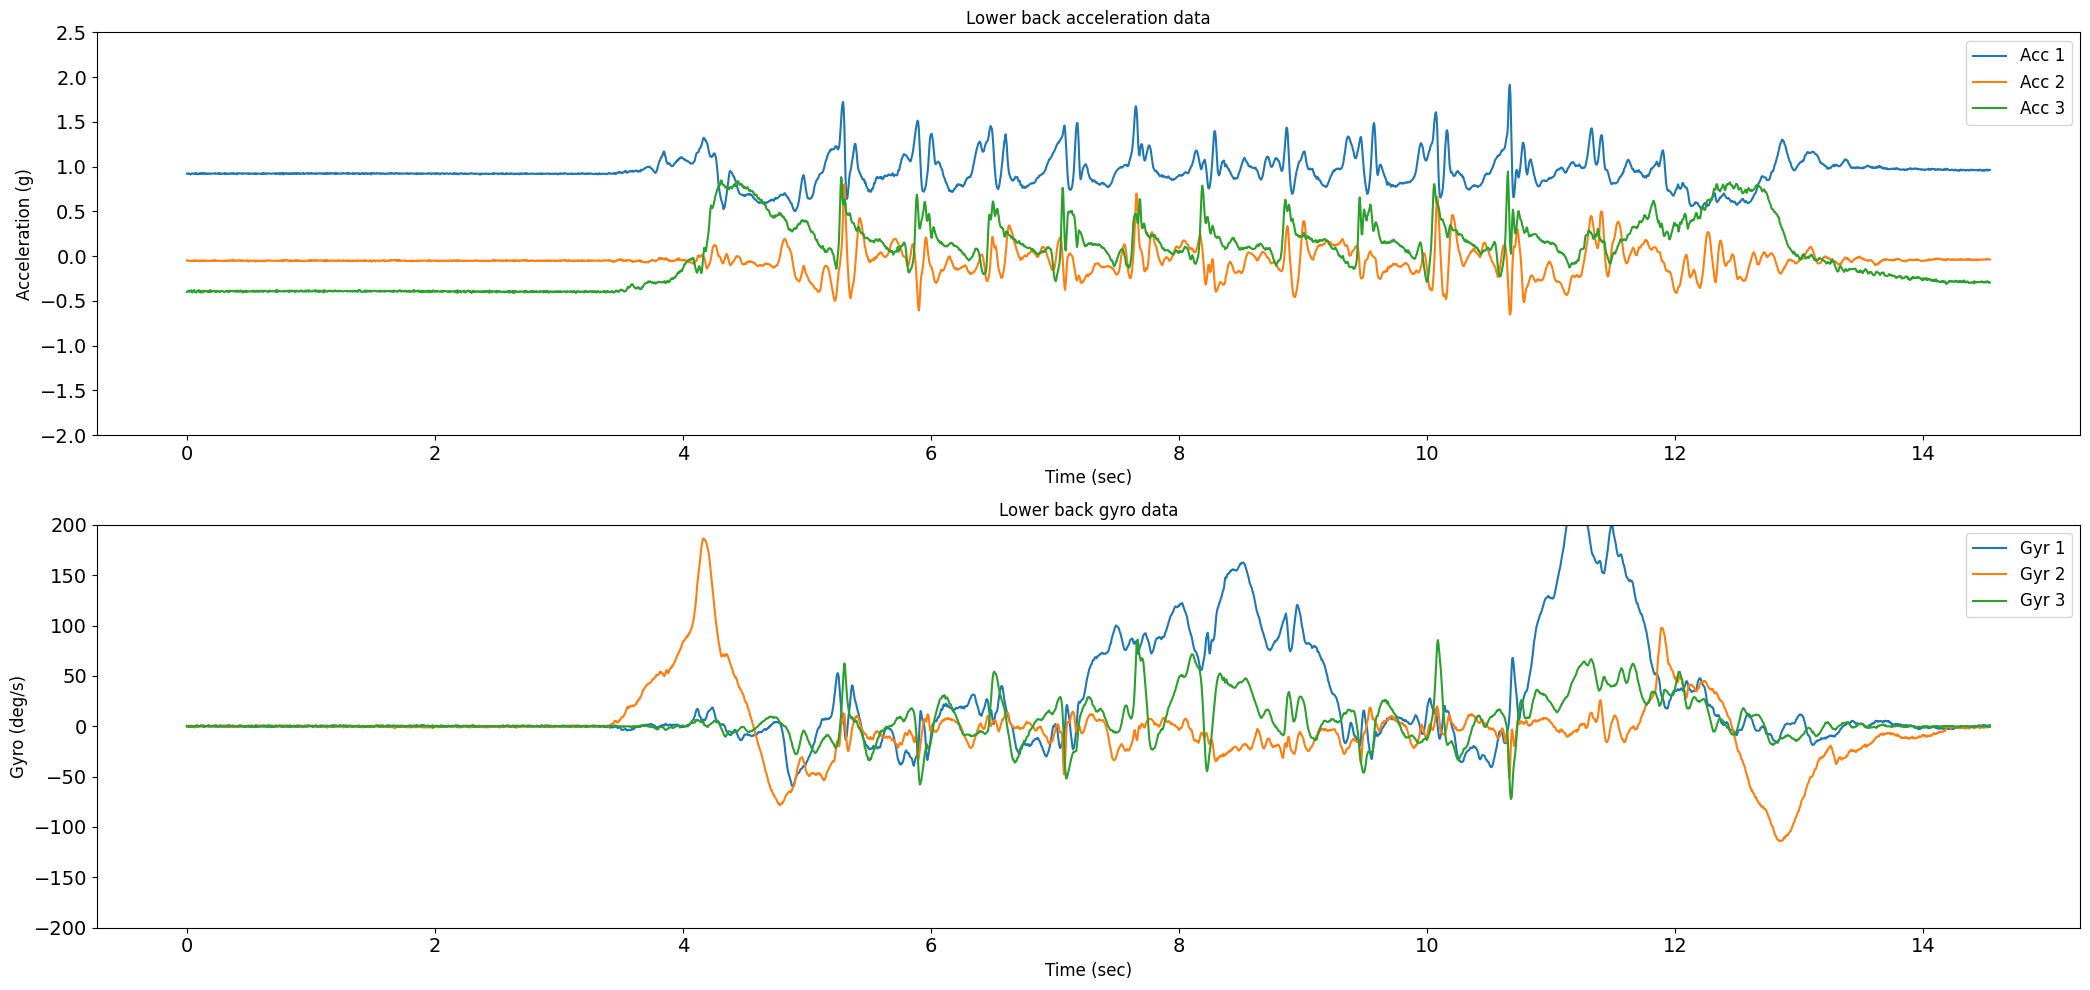

In [8]:
# Plot acceleration and gyro in subplots
fig = plt.figure(figsize=(21, 10))

# Subplot 1: Acceleration data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(acceleration_data)) / sampling_frequency,
        acceleration_data[f"pelvis_ACC_{chr(120 + i)}"],
        label=f"Acc {i + 1}",
    )
ax1.set_title("Lower back acceleration data")
ax1.set_ylabel(f"Acceleration (g)", fontsize=12)
ax1.set_xlabel(f"Time (sec)", fontsize=12)
ax1.legend(loc="upper right", fontsize=12)
ax1.set_ylim(-2, 2.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: Gyro data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_ANGVEL_{chr(120 + i)}"],
        label=f"Gyr {i + 1}",
    )
ax2.set_title("Lower back gyro data")
ax2.set_ylabel(f"Gyro (deg/s)", fontsize=12)
ax2.set_xlabel(f"Time (sec)", fontsize=12)
ax2.legend(loc="upper right", fontsize=12)
ax2.set_ylim(-200, 200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()


## Applying Pham sit to stand and stand to sit detection algorithm
Now, we are running Pham sit to stand and stand to sit detection algorithm from pham module [`NGMT.ngmt.modules.ssd._pham.SittoStandStandtoSitDetection`](https://github.com/neurogeriatricskiel/NGMT/tree/main/ngmt/modules/ssd/_pham.py) to detect sit to stand and stand to sit.

The following code first prepares the input data by combining acceleration and gyro data into a single DataFrame called `input_data`.

Then, in order to apply sit to stand and stand to sit algorithm, an instance of the PhamSittoStandStandtoSitDetection class is created using the constructor, `PhamSittoStandStandtoSitDetection()`. The `pham` variable holds this instance, allowing us to access its methods. The inputs of the algorithm are as follows:

- **Input Data:** `data` Includes accelerometer and gyro data (N, 6) for x, y, and z axes. in pandas Dataframe format.
- **Unit of acceleration data:** `acceleration_data_unit` is the unit of the acceleation data.
- **Unit of gyro data:** `gyro_data_unit` is unit of the gyro data.
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the data, defined in Hz, with a default value of 200 Hz.
- **Plot Results:** `plot_results`, if set to True, generates a plot showing the detected sit to stand and stand to sit movements on the data. The default is False. The onset is represented with the vertical red line and the grey area represents the duration of the postural transition (sit to stand or stand to sit) detected by the algorithm.

c:\Users\Project\anaconda3\envs\venv_ngmt\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 10 is too high: all coefficients will experience boundary effects.
  warnings.warn(


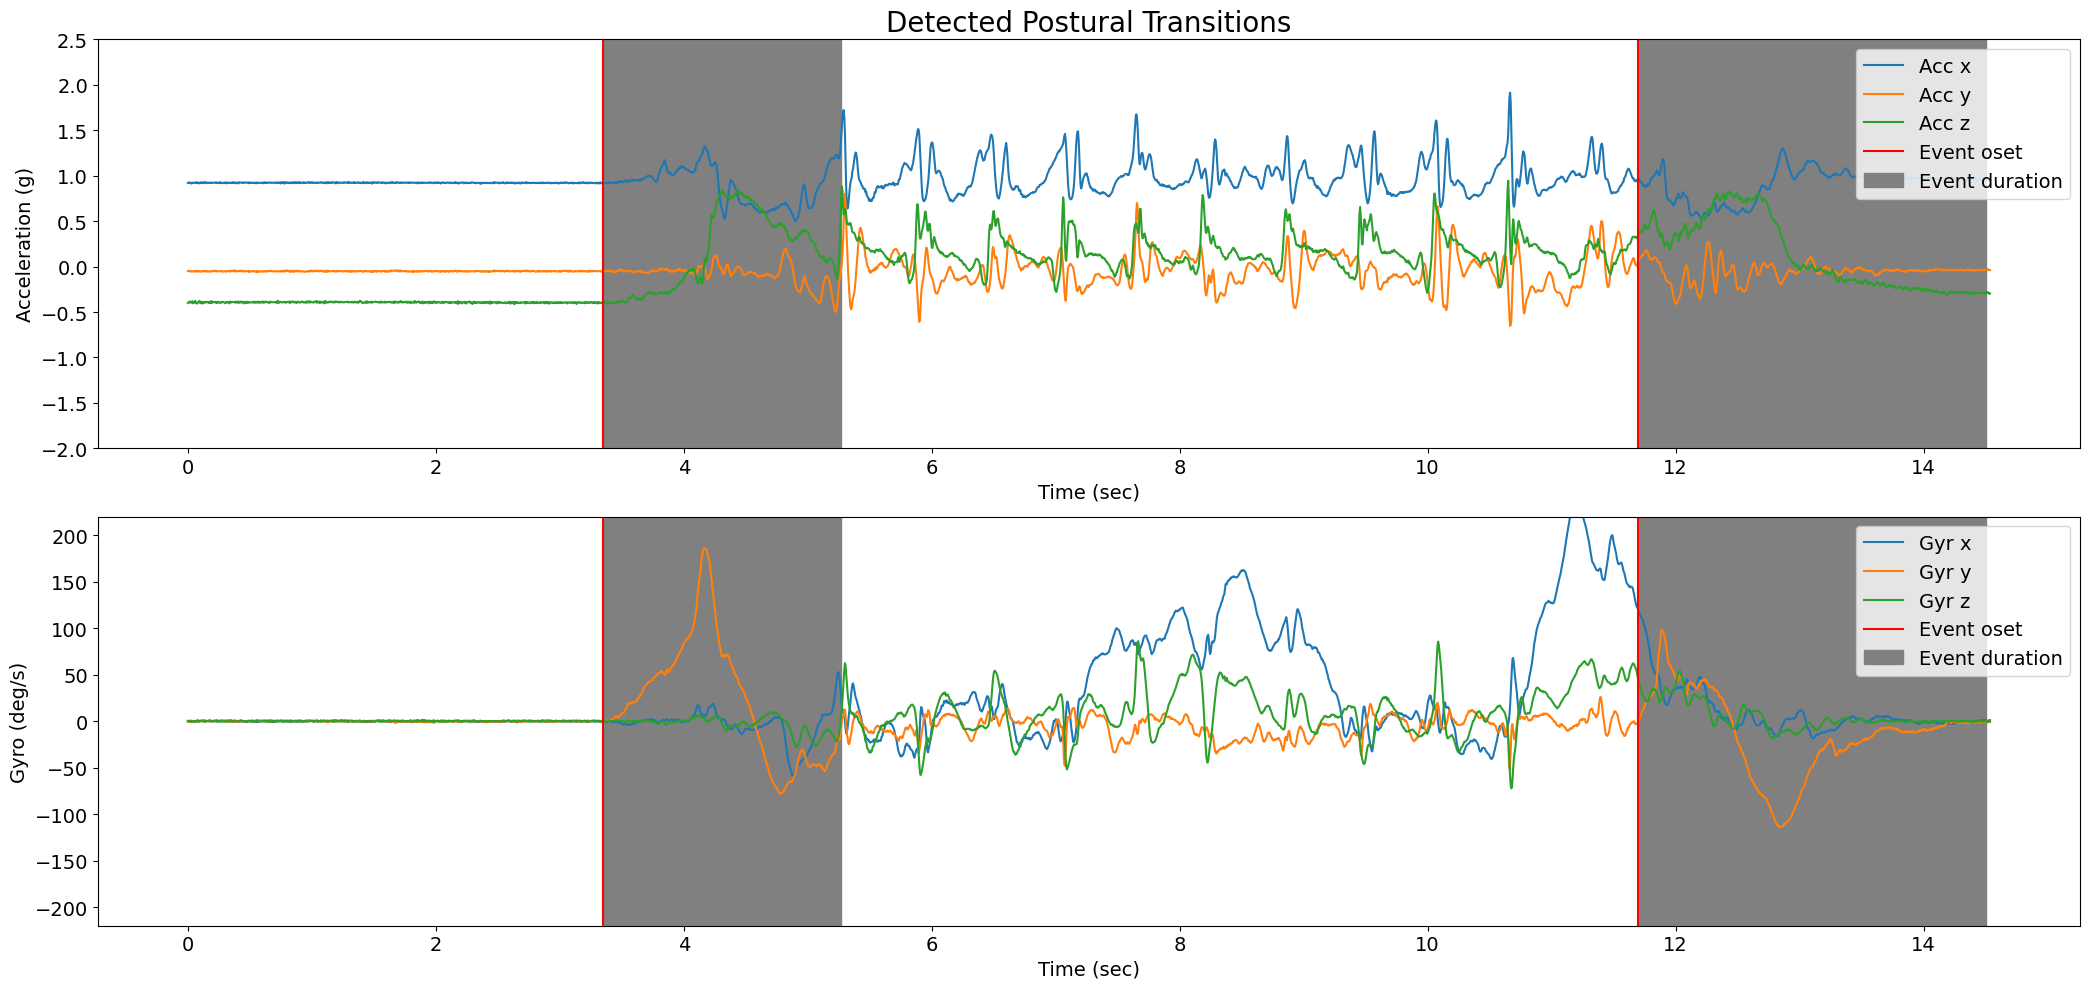

In [9]:
# Put acceleration and gyro data in the input data as pandas Dataframe which will be used as input of the algorithm
input_data = [acceleration_data, gyro_data]

# Concatenate acceleration_data and gyro_data along axis=1 (columns)
input_data = pd.concat([acceleration_data, gyro_data], axis=1)

# Create an instance of the PhamSittoStandStandtoSitDetection class
pham = PhamSittoStandStandtoSitDetection()

# Call the sit to satnd and stand to sit detection using pham.detect
pham = pham.detect(
    data=input_data,
    acceleration_data_unit=acceleration_data_unit,
    gyro_data_unit=gyro_data_unit,
    sampling_freq_Hz=sampling_frequency,
    plot_results=True
)

The postural transition information is stored in the 'postural_transitions_' attribute, which is a pandas DataFrame in BIDS format with the following columns:

- **onset**: Start of the event (sit to stand or stand to sit) in seconds.
- **duration**: Duration of the event in seconds.
- **event type**: Event type which is either sit to stand or stand to sit.
- **postural transition angle**: Angle of the postural transition in degree [°].
- **maximum flexion velocity**: Maximum flexion velocity [°/s].
- **maximum extension velocity**: Maximum extension velocity [°/s].
- **tracking_systems**: Tracking system which is 'imu' for this example.
- **tracked_points**: Tracked points on the body which is 'LowerBack' for this example.

In [10]:
# Print events and their corresponding information
postural_transition_events = pham.postural_transitions_
print(f"postural_transition_events: {postural_transition_events}")

postural_transition_events:     onset  duration    event_type  postural transition angle  \
0   3.345     1.925  sit to stand                  71.636257   
1  11.695     2.805  stand to sit                  29.257563   

   maximum flexion velocity  maximum extension velocity tracking_systems  \
0                       186                          78              imu   
1                        97                         113              imu   

  tracked_points  
0      LowerBack  
1      LowerBack  


## Detailed Visualization of the Detected Postural Transitions

To get a better understanding of the results, we can plot the data and the first detected postural transition (here is sit to stand). The red vertical line shows the onset and the grey area shows the duration of the first postural transition.

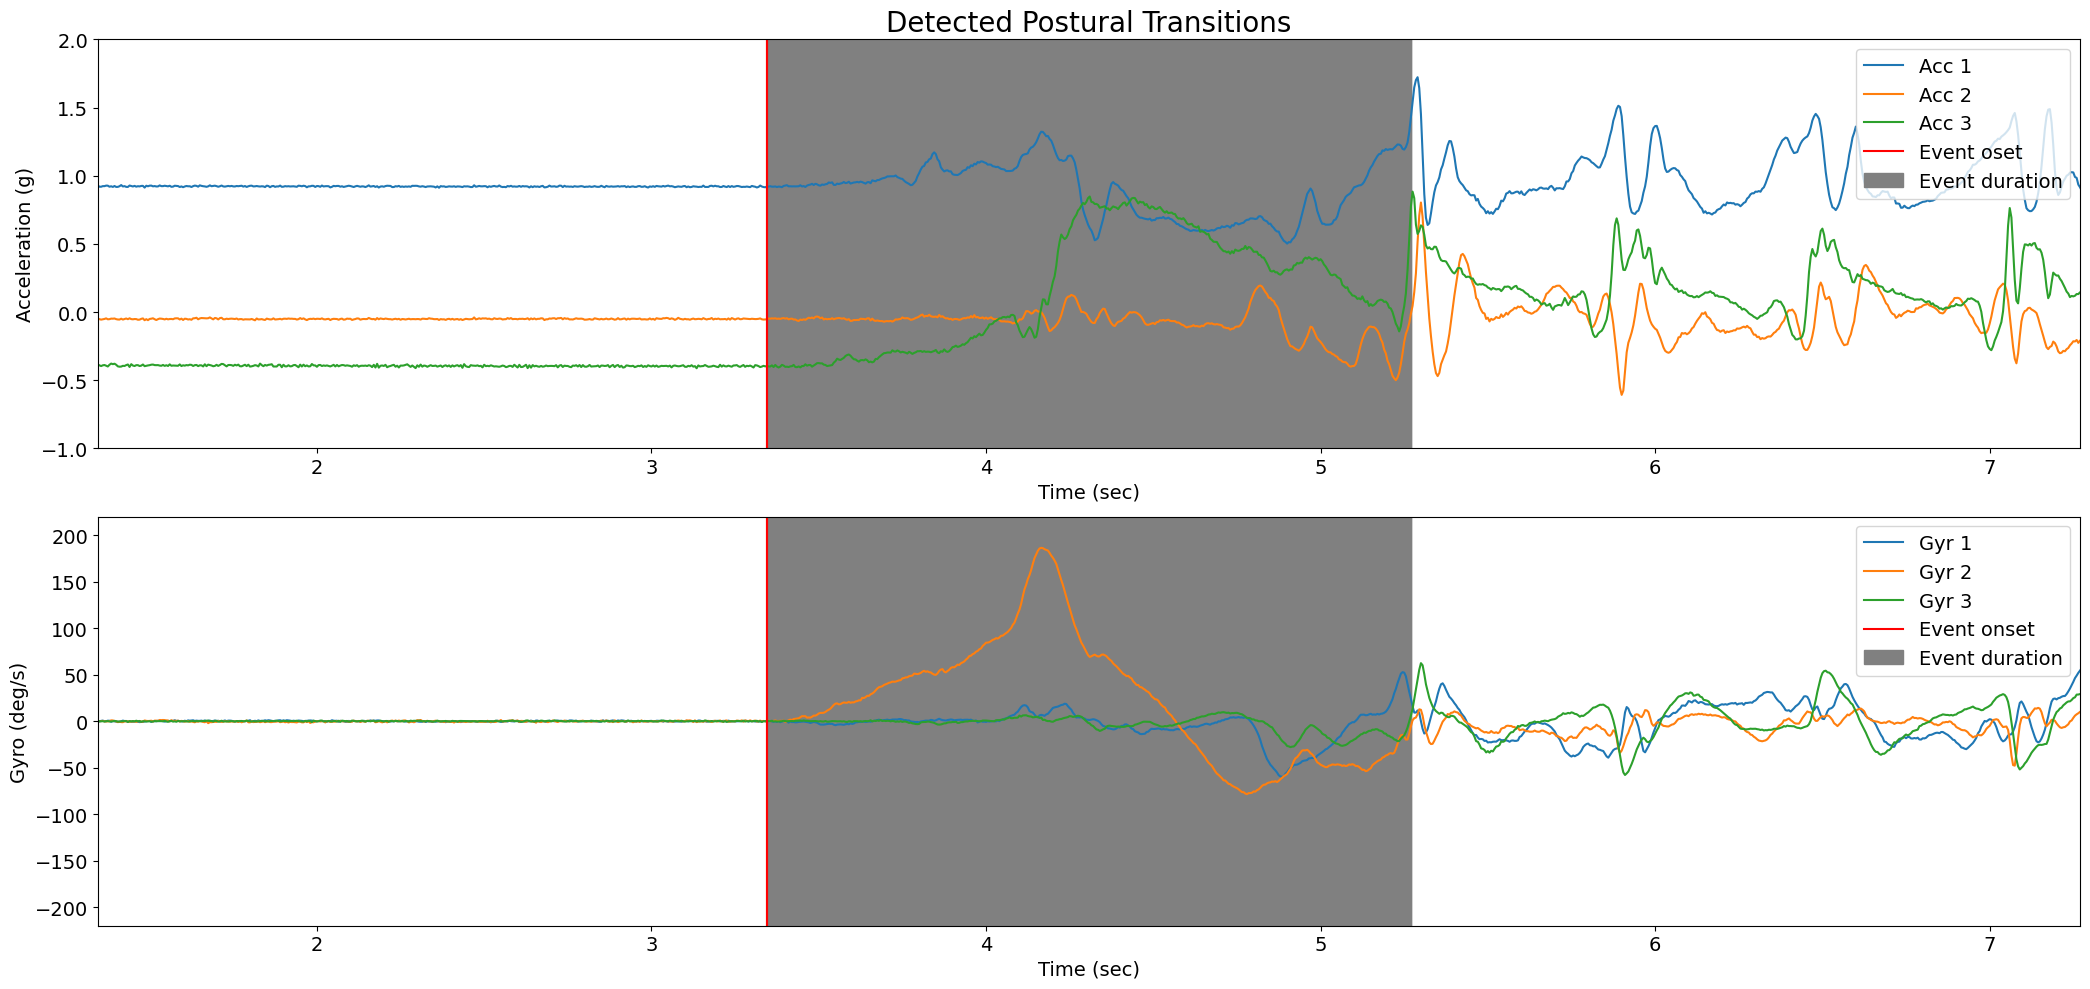

In [11]:
# Figure 
fig = plt.figure(figsize=(21, 10))

# Subplot 1: Acceleration data
ax1 = plt.subplot(211)
for i in range(3):
    ax1.plot(
        np.arange(len(acceleration_data)) / sampling_frequency,
        acceleration_data[f"pelvis_ACC_{chr(120 + i)}"],
    )
for i in range(len(postural_transition_events)):
    onset = postural_transition_events['onset'][0]
    duration = postural_transition_events['duration'][0]
    ax1.axvline(x=onset, color='r')
    ax1.axvspan(onset, (onset + duration), color='grey')
ax1.set_title("Detected Postural Transitions", fontsize=20)
ax1.set_ylabel(f"Acceleration (g)", fontsize=14)
ax1.set_xlabel(f"Time (sec)", fontsize=14)
ax1.legend(["Acc 1", "Acc 2", "Acc 3", "Event oset", "Event duration"], loc="upper right", fontsize=14)
ax1.set_ylim(-1, 2)
start_limit = postural_transition_events["onset"][0] - 2
end_limit = postural_transition_events["onset"][0] + postural_transition_events["duration"][0] + 2
ax1.set_xlim(start_limit, end_limit)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Subplot 2: Gyro data
ax2 = plt.subplot(212)
for i in range(3):
    ax2.plot(
        np.arange(len(gyro_data)) / sampling_frequency,
        gyro_data[f"pelvis_ANGVEL_{chr(120 + i)}"],
    )
for i in range(len(postural_transition_events)):
    onset = postural_transition_events['onset'][0]
    duration = postural_transition_events['duration'][0]
    ax2.axvline(x=onset, color='r')
    ax2.axvspan(onset, (onset + duration), color='grey')
ax1.set_title("Detected Postural Transitions", fontsize=20)
ax2.set_ylabel(f"Gyro (deg/s)", fontsize=14)
ax2.set_xlabel(f"Time (sec)", fontsize=14)
start_limit = postural_transition_events["onset"][0] - 2
end_limit = postural_transition_events["onset"][0] + postural_transition_events["duration"][0] + 2
ax2.set_xlim(start_limit, end_limit)
ax2.legend(["Gyr 1", "Gyr 2", "Gyr 3", "Event onset", "Event duration"], loc="upper right", fontsize=14)
ax2.set_ylim(-220, 220)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.tight_layout()
plt.show()